# Goal

Use time series analysis to project future traffic patterns 

## Dataset
Traffic Flow Data Jan to June 2022 SDCC
https://data.gov.ie/dataset/traffic-flow-data-jan-to-june-2022-sdcc

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Traffic_Flow_Data.csv')

In [3]:
data.head()

,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc,ObjectId
0,N01111A,TU,04/01/2022,2022/11/07 03:00:00+00,03:15,13,100,0,100,0,0,1
1,N01111A,TU,04/01/2022,2022/11/07 03:15:00+00,03:30,10,100,0,100,0,0,2
2,N01111A,TU,04/01/2022,2022/11/07 03:30:00+00,03:45,0,100,0,100,0,0,3
3,N01111A,TU,04/01/2022,2022/11/07 03:45:00+00,04:00,9,100,0,100,0,0,4
4,N01111A,TU,04/01/2022,2022/11/07 04:00:00+00,04:15,0,100,0,100,0,0,5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   site        1048575 non-null  object
 1   day         1048575 non-null  object
 2   date        1048575 non-null  object
 3   start_time  1048575 non-null  object
 4   end_time    1048575 non-null  object
 5   flow        1048575 non-null  int64 
 6   flow_pc     1048575 non-null  int64 
 7   cong        1048575 non-null  int64 
 8   cong_pc     1048575 non-null  int64 
 9   dsat        1048575 non-null  int64 
 10  dsat_pc     1048575 non-null  int64 
 11  ObjectId    1048575 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 96.0+ MB


## Feature Engineering

Some of this data isn't going to be beneficial for this analysis. As such, we can delete those rows and columns. 
Additionally, we might want to decomposed the date-time values 


In [5]:
# delete the values 
columns_to_drop = ['cong', 'cong_pc', 'dsat', 'dsat_pc', 'ObjectId','flow_pc']
data = data.drop(columns_to_drop, axis=1)

In [6]:
data['date'].info
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data.set_index('date', inplace=True)
data.head()

,site,day,start_time,end_time,flow
date,,,,,
2022-01-04,N01111A,TU,2022/11/07 03:00:00+00,03:15,13
2022-01-04,N01111A,TU,2022/11/07 03:15:00+00,03:30,10
2022-01-04,N01111A,TU,2022/11/07 03:30:00+00,03:45,0
2022-01-04,N01111A,TU,2022/11/07 03:45:00+00,04:00,9
2022-01-04,N01111A,TU,2022/11/07 04:00:00+00,04:15,0


In [7]:
data['start_time'] = pd.to_datetime(data['start_time'], format='%Y/%m/%d %H:%M:%S%z')

#data['year'] = data['date'].dt.year
#data['month'] = data['date'].dt.month
#data['day'] = data['date'].dt.day
#data['hour'] = data['start_time'].dt.hour
#data['minute'] = data['start_time'].dt.minute
#data['second'] = data['start_time'].dt.second

data['start_time'] = data['start_time'].dt.strftime('%H:%M')

data.head()

,site,day,start_time,end_time,flow
date,,,,,
2022-01-04,N01111A,TU,03:00,03:15,13
2022-01-04,N01111A,TU,03:15,03:30,10
2022-01-04,N01111A,TU,03:30,03:45,0
2022-01-04,N01111A,TU,03:45,04:00,9
2022-01-04,N01111A,TU,04:00,04:15,0


In [8]:
unique_sites = data['site'].nunique()
print(f'Total number of unique sites: {unique_sites}')

##  61 unique sites

Total number of unique sites: 61


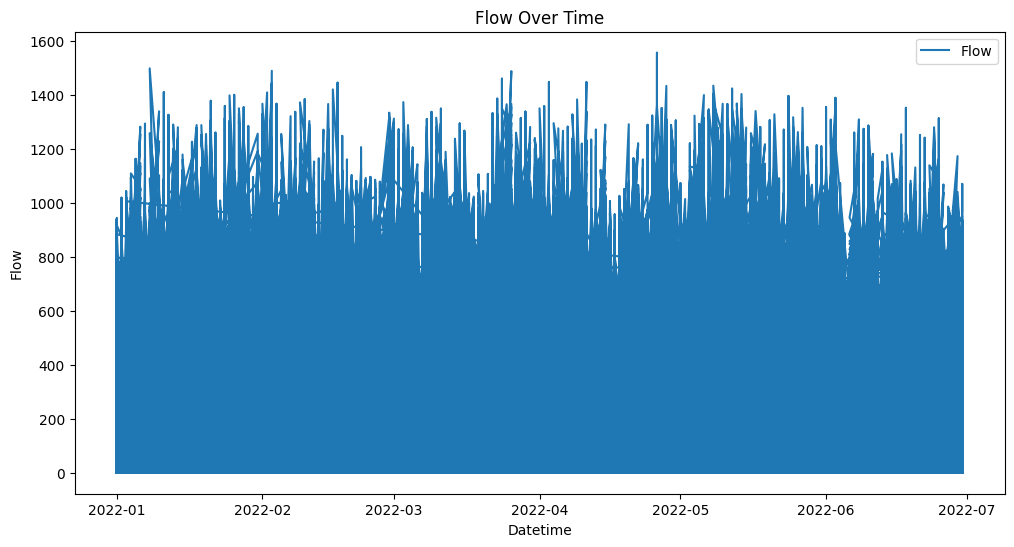

In [9]:
import matplotlib.pyplot as plt

# Assuming 'datetime_column' is the name of your datetime column
# and 'flow' is the name of your flow column
plt.figure(figsize=(12, 6))

# Plotting time data with respect to flow
plt.plot( data['flow'], label='Flow')

plt.title('Flow Over Time')
plt.xlabel('Datetime')
plt.ylabel('Flow')
plt.legend()
plt.show()

In [10]:
## lets add up the total flow for the day
daily_total_flow = data.groupby('date')['flow'].sum().reset_index()

In [11]:
daily_total_flow.set_index('date',inplace=True)

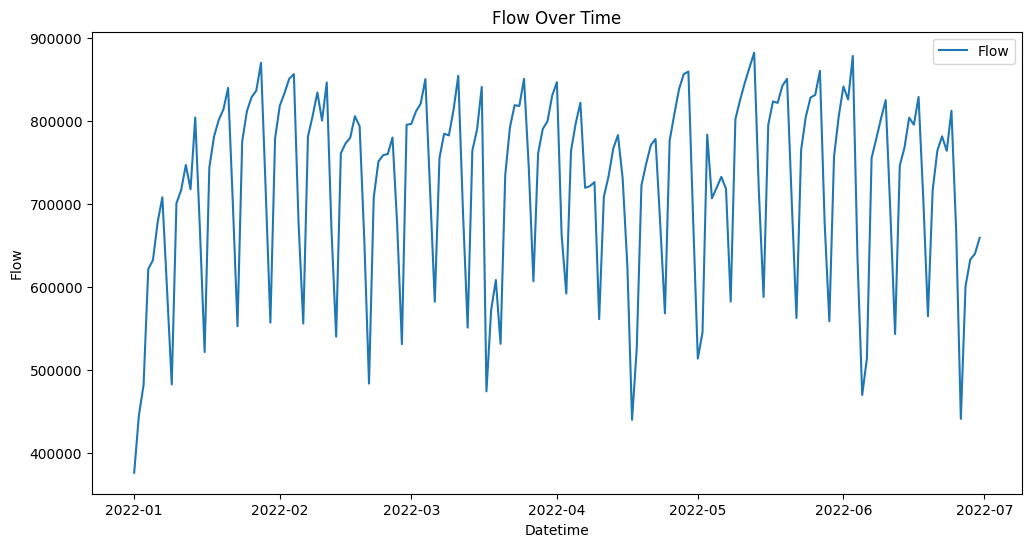

In [12]:
plt.figure(figsize=(12, 6))

# Plotting time data with respect to flow
plt.plot( daily_total_flow['flow'], label='Flow')

plt.title('Flow Over Time')
plt.xlabel('Datetime')
plt.ylabel('Flow')
plt.legend()
plt.show()

We can see that the flow very much corresponds with weekends and holidays. We will need to consider this during our analysis. 

In [13]:
## Basically going to break the data up into a train test split to see if it prediction matches actual values

split_date = pd.to_datetime('2022-06-01')

df_first= daily_total_flow[daily_total_flow.index < split_date]
df_month_six = daily_total_flow[daily_total_flow.index >= split_date]

df_month_six.head(5)

,flow
date,
2022-06-01,841188
2022-06-02,825623
2022-06-03,877955
2022-06-04,634329
2022-06-05,470119


# Data Analysis

We could go many direction... 
1. forecast future traffic patterns
2. train a model to determine what time to leave based on a given traffic pattern
3. look to see if there are any anomalies

## forecast future traffic patterns 

To do this, lets only consider daily traffic flow and try to make a prediction. 

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
df_first = df_first.asfreq('D')

In [16]:
df_first.tail(5)

,flow
date,
2022-05-27,859941
2022-05-28,677600
2022-05-29,558849
2022-05-30,756649
2022-05-31,805138


In [17]:
p, d, q = 1, 1, 1
model = ARIMA(df_first['flow'], order=(p, d, q))
results = model.fit()

In [18]:
# Forecast future values
forecast_steps = len(df_month_six)  # Want to predict this many days
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

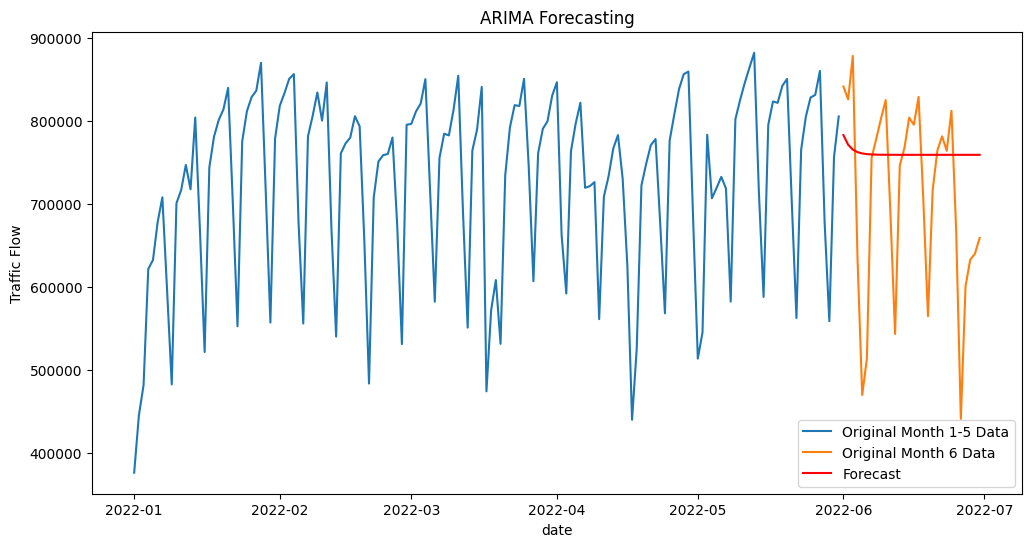

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_first['flow'], label='Original Month 1-5 Data')
plt.plot(df_month_six['flow'], label='Original Month 6 Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.title('ARIMA Forecasting')
plt.xlabel('date')
plt.ylabel('Traffic Flow')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(df_month_six['flow'], forecast_values)
mse = mean_squared_error(df_month_six['flow'], forecast_values)

print("mean_squared_error:", mse)


mean_squared_error: 15542819132.405622


high mean squared error means the model is behaving terribly. This is obvious from the graph. 

let's try again... this time considering seasonality. 

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example seasonal orders (adjust based on your analysis)
P, D, Q, S = 1, 1, 1, 7
sarima_model = SARIMAX(df_first['flow'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit(disp=False)

In [24]:
forecast_steps = len(df_month_six)  # Want to predict this many days
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean

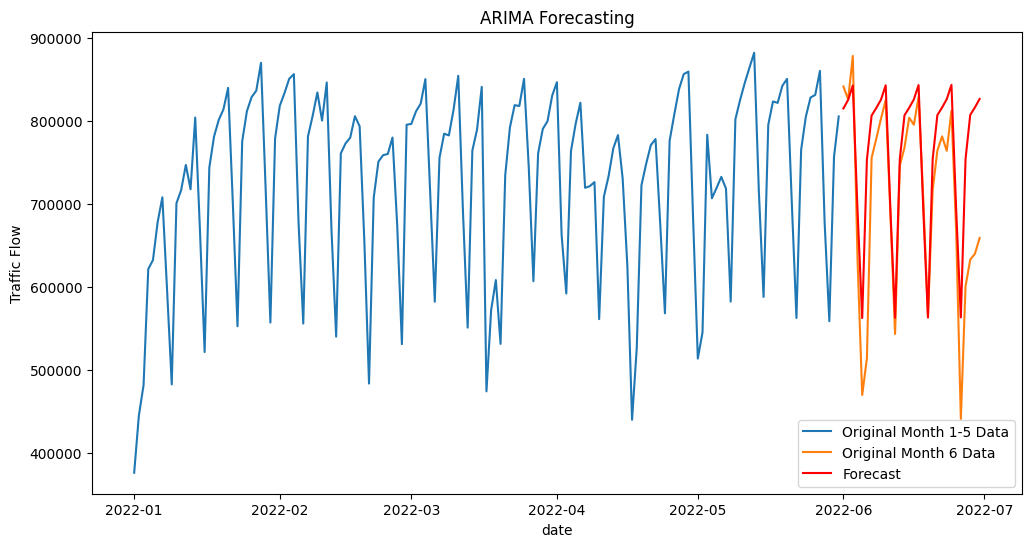

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df_first['flow'], label='Original Month 1-5 Data')
plt.plot(df_month_six['flow'], label='Original Month 6 Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.title('ARIMA Forecasting')
plt.xlabel('date')
plt.ylabel('Traffic Flow')
plt.legend()
plt.show()

Much better!!! 